In [ ]:
# !pip install numpy matplotlib cvxopt pandas yfinance finquant plotly cufflinks chart_studio pandas_datareader atoti atoti-jupyterlab

In [ ]:
%matplotlib inline
import random

import cvxopt as opt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from cvxopt import blas, solvers
from finquant.portfolio import build_portfolio
from scipy.optimize import minimize

np.random.seed(123)

# Turn off progress printing
solvers.options["show_progress"] = False
import concurrent.futures
import os
import random
import urllib
import urllib.request
from concurrent.futures import ALL_COMPLETED, wait

import atoti as tt
import cufflinks
import numpy as np
import pandas_market_calendars as mcal

# (*) To communicate with Plotly's server, sign in with credentials file
import plotly as py

# (*) Useful Python/Plotly tools
import plotly.tools as tls

# (*) Graph objects to piece together plots
from plotly.graph_objs import *

In [ ]:
# ndays = 252*10+7
ndays = 252 * 1.5 + 7
# ~training
dback = 252
# ~forecast
dahead = 20
# sample size
# if to randomize
rand = True
nran = 20
nstocks = 100
# this should match tbill 20, 91, 126, 252

end = pd.Timestamp.utcnow()
start = end - int(ndays) * pd.tseries.offsets.BDay()
one_week_end = end - int(ndays - 7) * pd.tseries.offsets.BDay()
one_week_end = one_week_end.strftime("%Y-%m-%d")
start = start.strftime("%Y-%m-%d")
end = end.strftime("%Y-%m-%d")

In [ ]:
# pd.tseries.offsets.BDay(100)
nyse = mcal.get_calendar("NYSE")

# Show available calendars
# print(mcal.get_calendar_names())
tradingDays = list(
    nyse.schedule(start_date=start, end_date=end).index.strftime("%Y-%m-%d")
)

In [ ]:
def rand_weights(n):
    """ Produces n random weights that sum to 1 """
    k = np.random.rand(n)
    return k / sum(k)


def weighted_return(returns, weights):
    w = weights

    p = np.asmatrix(np.mean(returns, axis=0))

    mu = np.asmatrix(w) * p.T
    return mu


def random_portfolio(returns):

    w = rand_weights(len(pd.DataFrame(returns).columns))

    p = np.asmatrix(np.mean(returns, axis=0))

    C = np.array(pd.DataFrame(returns).cov().values)

    mu = np.asmatrix(w) * p.T
    sigma = np.sqrt(np.asmatrix(w) * C * np.asmatrix(w).T)

    sharpe = mu / sigma

    return np.float(mu), np.float(sigma), np.float(sharpe), np.array(w, dtype=object)


def unique(list1):

    # intilize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    return unique_list


def split_sequences(sequences, n_steps_in, n_steps_out):

    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [ ]:
url = "ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqtraded.txt"

urllib.request.urlretrieve(url, "nasdaqtraded.txt")
urllib.request.urlretrieve(url, "mfundslist.txt")
urllib.request.urlretrieve(url, "bonds.txt")

df1 = pd.read_csv("nasdaqtraded.txt", sep="|")[0:-1]
df2 = pd.read_csv("mfundslist.txt", sep="|")[0:-1]
df3 = pd.read_csv("bonds.txt", sep="|")[0:-1]

# combined = pd.concat([df1['Symbol'],df2['Symbol'],df3['Symbol']],axis=0)

# process symbols for bad characters
BAD_CHARS = ["$", "."]
# pat = '|'.join(['({})'.format(re.escape(c)) for c in BAD_CHARS])
# cleaned = unique(combined.replace(BAD_CHARS,'-'))

# choose size
size = nstocks
# stocks = list(df1["Symbol"].sample(n=int(size/3)))
stocks = list(
    df1["Symbol"]
    .replace(".", "-")
    .replace("\\$", "-P", regex=True)
    .sample(n=int(size / 3))
)
mfunds = list(
    df2["Symbol"]
    .replace(".", "-")
    .replace("\\$", "-P", regex=True)
    .sample(n=int(size / 3))
)
bonds = list(
    df3["Symbol"]
    .replace(".", "-")
    .replace("\\$", "-P", regex=True)
    .sample(n=int(size / 3))
)
symbols = list(set(stocks + mfunds + bonds))  # unique(stocks + mfunds + bonds)
# symbols = unique(stocks)

In [ ]:
print(start, one_week_end)

In [ ]:
pf_pre = build_portfolio(
    names=symbols, start_date=start, end_date=one_week_end, data_api="yfinance"
)

In [ ]:
vetted_symbols = list(
    pf_pre.data.loc[
        (np.intersect1d(list(pf_pre.data.index.strftime("%Y-%m-%d")), tradingDays))
    ]
    .head(-1)
    .tail(-1)
    .dropna(axis=1)
    .columns
)

In [ ]:
# combinedList = unique(list(np.append(random.sample(symbols_sp500,int(len(symbols_sp500)*.05)),np.append(random.sample(dividendAristocraft,int(len(dividendAristocraft)*.25)),np.append(top10,random.sample(symbols_ns100,int(len(symbols_ns100)*.25)))))))

# add index
# vetted_symbols.append('TQQQ')

pf = build_portfolio(
    names=list(vetted_symbols), start_date=start, end_date=end, data_api="yfinance"
)

In [ ]:
"""
import pandas_datareader.data as web

import datetime

# Multiple series:
fred_data = web.DataReader(FRED_Indicators, 'fred', start, end)
"""

FRED_Indicators = ["DTB4WK", "DTB3", "DTB6", "DTB1YR"]

import pandas_datareader.data as web


def Fred_Data(name):
    temp = web.DataReader(str(name), "fred", start, end)
    temp.index = pd.to_datetime(temp.index)
    # temp = temp.resample(frequency).mean().dropna()
    return temp


FRED_set = []
FRED_completed = []
for i in FRED_Indicators:
    FRED_completed.append(i)
    FRED_set.append(Fred_Data(i))

FRED_pvt = pd.DataFrame()

for x in range(0, len(FRED_completed)):
    values = FRED_set[x]
    values = values.loc[~values.index.duplicated(keep="last")]

    FRED_pvt = pd.concat([FRED_pvt, values], axis=1)

In [ ]:
returns = np.log(
    1
    + pf.data.loc[
        (np.intersect1d(list(pf.data.index.strftime("%Y-%m-%d")), tradingDays))
    ]
    .head(-1)
    .interpolate(method="time")
    .pct_change()
    .tail(-1)
)
returns = returns.dropna(axis=1)
# returns.columns = stocks.dropna(axis=1)
len(returns.columns)
# np.sum(returns.isin([np.inf, -np.inf, np.NaN])).sort_values(kind="quicksort", ascending=True)

In [ ]:
selectedmfunds = set(mfunds) & set(returns.columns)
selectedstocks = set(stocks) & set(returns.columns)
selectedbonds = set(bonds) & set(returns.columns)

In [ ]:
n_steps_in = dback

n_steps_out = dahead

Training, Holdout = split_sequences(
    np.array(pd.DataFrame(returns.index.strftime("%Y-%m-%d"))), n_steps_in, n_steps_out
)

100

,0
0,2021-04-29
1,2021-04-30
2,2021-05-03
3,2021-05-04
4,2021-05-05


In [ ]:
randomSet = list(np.sort(np.random.choice(range(0, len(Training)), nran)))

randomsymbols = list(np.random.choice(pf.data.columns, 10, replace=False))

# random columns
stocks = returns.loc[[i[0] for i in Training[randomSet[1]]]][randomsymbols]

"""
returns_table = session.read_csv(
    "returns.csv", keys=["stock"], store_name="Returns", array_sep=";"
)

returns_table.head()
"""
return_vec = np.array(stocks)

In [ ]:
stocks[randomsymbols]

In [ ]:
# data = pd.DataFrame()
# for i in randomsymbols:
#     data = pd.concat([pd.DataFrame({i: [stocks[i].values]}), data], axis=1)

In [ ]:
# data.transpose()

### Converting daily returns into list

In [ ]:
data_transpose = stocks[randomsymbols].T
data_transpose.head()

In [ ]:
data_transpose['returns_vector'] = data_transpose.values.tolist()
data_transpose['returns_vector'].head()

In [ ]:
return_vector = data_transpose['returns_vector'].to_frame()
return_vector["symbol"] = return_vector.index
return_vector.head()

### Getting list of dates for the return list

In [ ]:
ret = stocks.reset_index().copy()
ret["Date"].head()

In [ ]:
import atoti as tt


In [ ]:
session = tt.create_session()

In [ ]:
# https://towardsdatascience.com/shape-tables-like-jelly-with-pandas-melt-and-pivot-f2e13e666d6

returns_table = session.read_pandas(
    return_vector,
    table_name="Returns",
    keys=["symbol"],
    #store_name="Returns",
)

returns_table.head()

In [ ]:
cube = session.create_cube(returns_table, "Return Cube")

In [ ]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [ ]:
# import graphviz
cube.schema

In [ ]:
# pip list

In [49]:
# years = 10

import contextlib

stocksp = 0.2
mfundsp = 0.1
bondsp = 0.2
commp = 0.2

n_portfolio = 100

bestSharpe = 0
runs = 0
weight = None
bestMean = 0
bestStd = 0
means = np.array([])
stds = np.array([])
sharpes = np.array([])
bestWeights = None
weights = np.array([])

# random dates using X_index

randomSet = list(np.sort(np.random.choice(range(0, len(Training)), nran)))

for tensor in randomSet:

    randomsymbols = list(np.random.choice(pf.data.columns, 10, replace=False))
    # random columns
    stocks = returns.loc[[i[0] for i in X_index[tensor]]][randomsymbols]

    return_vec = np.array(stocks)

    # display(pd.DataFrame(stocks.cumsum().iloc[-1]).transpose())

    for _ in range(n_portfolio):
        means2, stds2, sharpes2, weights2 = np.column_stack(
            [random_portfolio(return_vec) for _ in range(len(stocks.columns))]
        )
        means_ = means2
        stds_ = stds2
        sharpes_ = sharpes2
        weights_ = weights2

        bestWeights = weights_[sharpes_.argmax()]

        means = np.append(means, means_)
        stds = np.append(stds, stds_)
        sharpes = np.append(sharpes, sharpes_)
        weights = np.append(weights, weights_)

    df_ = pd.DataFrame(weights[sharpes.argmax()]).set_index(stocks.columns)
    df_.columns = ["Weights"]

    next4weeks = returns.loc[[i[0] for i in Holdout[tensor]]][randomsymbols]

    df_.sort_values(by=["Weights"], ascending=False, inplace=True)

    wr = np.array(
        weighted_return(
            np.array((np.exp(next4weeks) - 1).cumsum().tail(1)),
            weights[sharpes.argmax()],
        )
    )[0][0]

    max_sr_ret = means[sharpes.argmax()]
    max_sr_vol = stds[sharpes.argmax()]
    max_sharpe = sharpes[sharpes.argmax()]

    display([bestWeights, max_sr_ret, max_sr_vol, max_sharpe, wr])

C:\Users\User\AppData\Local\Temp/ipykernel_8536/1205890402.py:29: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[array([0.07247439714508115, 0.059824846594602465, 0.03396778413551096,
        0.02083342124206978, 0.1254806130830465, 0.17375005518508843,
        0.11006886482550535, 0.03458306170051504, 0.19544521244152843,
        0.17357174364705194], dtype=object),
 0.002282125555795927,
 0.013516549176134297,
 0.1688393632174547,
 0.06462693285538185]

[array([0.03642237409029684, 0.2021679174213081, 0.058480974255746485,
        0.10523688710899201, 0.03004159379005753, 0.18962262334994756,
        0.03747301353727017, 0.11011886681687741, 0.17279298413120994,
        0.057642765498294], dtype=object),
 0.002282125555795927,
 0.013516549176134297,
 0.1688393632174547,
 0.04439485808798905]

[array([0.30025813021122355, 0.14627367182138443, 0.011604608335961514,
        0.21137789984367186, 0.01980296823541222, 0.03347287468135748,
        0.03332316175805822, 0.025582232926722015, 0.021848562009791597,
        0.196455890176417], dtype=object),
 0.002187097109760244,
 0.010073101229751254,
 0.21712251866392218,
 0.0036266536582282224]

[array([0.10968707849365844, 0.11824221989186808, 0.0860929321760973,
        0.08467180005276535, 0.05572073382469178, 0.2124362600355575,
        0.046071279006249306, 0.032520542521144724, 0.2008906941306896,
        0.053666459867278], dtype=object),
 0.002187097109760244,
 0.010073101229751254,
 0.21712251866392218,
 -0.08361457388254921]

[array([0.046032356338773804, 0.1681377179041525, 0.16431077973130995,
        0.0715040332926456, 0.07752485988608519, 0.1418545729627126,
        0.04816173548967901, 0.1353794090132875, 0.0620172278798387,
        0.08507730750151517], dtype=object),
 0.002187097109760244,
 0.010073101229751254,
 0.21712251866392218,
 -0.07074758031143226]

[array([0.13437065055271322, 0.06500463630326506, 0.07906724299967094,
        0.12935458926408405, 0.1422575734992756, 0.07126047411689651,
        0.1634276639934162, 0.07519723607434457, 0.10281381159871915,
        0.03724612159761476], dtype=object),
 0.002187097109760244,
 0.010073101229751254,
 0.21712251866392218,
 -0.04256819357811627]

[array([0.0752858582315164, 0.10958934498850414, 0.03265027937364398,
        0.1658537285779408, 0.026497220635460516, 0.10071039053315703,
        0.08441936589667105, 0.11548049261098445, 0.17116906007416277,
        0.1183442590779587], dtype=object),
 0.002187097109760244,
 0.010073101229751254,
 0.21712251866392218,
 -0.03590226645062177]

[array([0.12793997313897737, 0.04728492538416499, 0.08296395232813268,
        0.1538716039635059, 0.0014544002698342463, 0.11360346167741588,
        0.16108352031080278, 0.04389276351922885, 0.1697862989519348,
        0.09811910045600236], dtype=object),
 0.002187097109760244,
 0.010073101229751254,
 0.21712251866392218,
 -0.04556630666825095]

[array([0.11506990072172038, 0.14252417299847153, 0.06598283126460609,
        0.09058146551578898, 0.05481282849794883, 0.15954128316928948,
        0.11403735678115734, 0.05306619453832182, 0.06307853169804703,
        0.14130543481464844], dtype=object),
 0.002187097109760244,
 0.010073101229751254,
 0.21712251866392218,
 0.043785450093853234]

[array([0.09961236713416137, 0.0465156120005793, 0.177779957399558,
        0.16557423347196223, 0.0891910757524983, 0.10997991774575848,
        0.06355129128396306, 0.0050300408314106464, 0.17428870020349815,
        0.06847680417661045], dtype=object),
 0.002187097109760244,
 0.010073101229751254,
 0.21712251866392218,
 0.041143680088928825]

[array([0.10611971074855561, 0.10495120608524929, 0.01607778099149348,
        0.008653783345454072, 0.0625833318872547, 0.16516818455046964,
        0.00659027547358777, 0.20426100225798907, 0.14777270559875197,
        0.17782201906119446], dtype=object),
 0.002187097109760244,
 0.010073101229751254,
 0.21712251866392218,
 -0.012008735608340803]

[array([0.17207584511550833, 0.057046553380767515, 0.18781969908527704,
        0.015340368635006022, 0.035720827146577386, 0.1704833604829974,
        0.04533998415506432, 0.16567220912596142, 0.14046326349657293,
        0.010037889376267714], dtype=object),
 0.002187097109760244,
 0.010073101229751254,
 0.21712251866392218,
 -0.001563342105247105]

[array([0.11140592164559855, 0.02144225367631816, 0.1245376668881685,
        0.012456473687939154, 0.1988360575476952, 0.1314625808856504,
        0.1635725496840516, 0.06604081380058037, 0.07642785356845341,
        0.09381782861554451], dtype=object),
 0.002187097109760244,
 0.010073101229751254,
 0.21712251866392218,
 0.10941008332908947]

[array([0.15380270885755318, 0.049790914622046045, 0.1279986454332531,
        0.07645550979832966, 0.0110397881647455, 0.08389101492071782,
        0.058455033243160606, 0.14514805189861923, 0.13586121610704088,
        0.157557116954534], dtype=object),
 0.002187097109760244,
 0.010073101229751254,
 0.21712251866392218,
 -0.017455478510555265]

[array([0.0987842260779657, 0.09340055195103397, 0.1839978842606241,
        0.194798889629423, 0.10357413913347566, 0.011576809058507841,
        0.13807181266903112, 0.13212229386996466, 0.01380178966086955,
        0.02987160368910453], dtype=object),
 0.002187097109760244,
 0.010073101229751254,
 0.21712251866392218,
 0.0295370808118581]

[array([0.021989501689319225, 0.1312252943578792, 0.19043971358273518,
        0.047592313395070265, 0.02149788992267377, 0.11132255404411805,
        0.21925264090407534, 0.06125601908141872, 0.0140047503331921,
        0.18141932268951808], dtype=object),
 0.002187097109760244,
 0.010073101229751254,
 0.21712251866392218,
 0.005830809789139315]

[array([0.13734909709303117, 0.09079175857217303, 0.020341315796413625,
        0.1831087188805036, 0.053293735955084104, 0.1259507221387361,
        0.021127843361805253, 0.14779687656233922, 0.1252499356962084,
        0.09498999594370555], dtype=object),
 0.002187097109760244,
 0.010073101229751254,
 0.21712251866392218,
 -0.011036659929925311]

[array([0.15552450152916075, 0.07570118782836961, 0.18435036825550008,
        0.17355721400421692, 0.04926317878413618, 0.04014720712516601,
        0.08035312775322384, 0.0019501842304438446, 0.11394251708736106,
        0.12521051340242176], dtype=object),
 0.00176988041321387,
 0.007998404943661011,
 0.22127917074473158,
 0.006716325006388881]

[array([0.14136269133586102, 0.07074019900961666, 0.18349350425848487,
        0.06004714924845043, 0.02260750682392557, 0.13357533009011469,
        0.17514771767274995, 0.00795842429723642, 0.11058041511640299,
        0.0944870621471574], dtype=object),
 0.00176988041321387,
 0.007998404943661011,
 0.22127917074473158,
 -0.004786083808793607]

[array([0.11158491936682016, 0.12334984293085098, 0.11514786463429157,
        0.07004290293665638, 0.06251003230591656, 0.07080914043263009,
        0.03561944922079688, 0.18964210024505618, 0.16578127396269854,
        0.05551247396428265], dtype=object),
 0.0016690959848363668,
 0.006723909585541146,
 0.24823296083955843,
 0.022203818032095247]

In [54]:
cube.create_parameter_hierarchy_from_members(
    "Dates", ret["Date"].tolist(), 
    #index_measure="Date Index",
    #store_name="Dates"
)
# Setting the hierarchy to non-slicing, as required by
# the max_member aggregation function - see later - this behavior might change in future versions.
h["Dates"].slicing = False

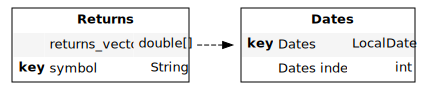

In [55]:
cube.schema

ValueError: DataFrame constructor not properly called!

In [57]:
m["daily returns"] = m["returns_vector.SUM"][m["Date Index"]]
#m["daily returns"].formatter = "DOUBLE[#,###.0000000000]"

KeyError: 'No measure named Dates'

In [69]:
randomsymbols[1]

'IMKTA'

In [ ]:
session.visualize()

In [ ]:
session.visualize("Daily returns for symbol BXP")